In [1]:
import os

import av
import numpy as np
import pandas as pd
from torchvision import models
from torchvision.transforms import transforms


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from utils.video_processing import sample_frame_indices, read_video_pyav

In [2]:
df = pd.read_csv("data\kinetics_700\dancing.csv")
df["video_path"] = "data/kinetics_700/clips_2/" + df["youtube_id"] + ".mp4"

for i, row in df.iterrows():
    if not os.path.exists(row['video_path']):
        df.drop(i, inplace=True)
df.reset_index(drop=True, inplace=True)

X_train, X_val, _, _ = train_test_split(df, df['label'])
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

labels = X_train["label"].unique()
labels2id = {label: i for i, label in enumerate(labels)}

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
class VideoDataset(Dataset):
    def __init__(self, meta, max_length=128, transform=None):
        self.meta = meta
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        video = self.load_video(row['video_path'])
        # video = apply_video_augmentations(video, self.transform)
        for i in range(len(video)):
            video[i] = self.transform(video[i])
        video = torch.stack(video)
        labels_tensor = labels2id[self.meta['label'].iloc[idx]]
        labels_tensor = torch.tensor([labels_tensor] * len(video))
        return video, labels_tensor

    def load_video(self, path):
        container = av.open(path)
        indices = sample_frame_indices(clip_len=8, frame_sample_rate=5,
                                       seg_len=container.streams.video[0].frames)
        video = read_video_pyav(container, indices)
        frames = []
        for frame in video:
            frame = frame.to_image()
            # frame = cv2.resize(frame.to_ndarray(format="rgb24"), (224, 224))
            frames.append(frame)
        return frames

In [4]:
val_dataset = VideoDataset(meta=X_val, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Validate model

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(512, 15)
model.to(device)

model.load_state_dict(torch.load("resnet18_9+20+10 (1).pkl"))

C:\Users\user\anaconda3\envs\cv-base\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\cv-base\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

### Regular validation per frame

In [27]:
val_targets = []
val_preds = []

for i, batch in enumerate(val_dataloader):
    val_input, val_labels = batch
    # val_input = torch.swapaxes(val_input, 1, -2)

    grouped_inputs, grouped_labels = batch

    val_input = grouped_inputs.flatten(0, 1)
    val_labels = grouped_labels.flatten()

    val_input = val_input.to(device)
    val_labels = val_labels.to(device)

    with torch.no_grad():
        outputs = model(val_input)

    val_targets.append(val_labels.detach().cpu().numpy())
    val_preds.append(outputs.argmax(1).detach().cpu().numpy())

val_targets = [item for sublist in val_targets for item in sublist]
val_preds = [item for sublist in val_preds for item in sublist]

print('F1:', f1_score(val_targets, val_preds, average='macro'))
print('Accuracy:', accuracy_score(val_targets, val_preds))

F1: 0.062352059912902984
Accuracy: 0.06680253623188406


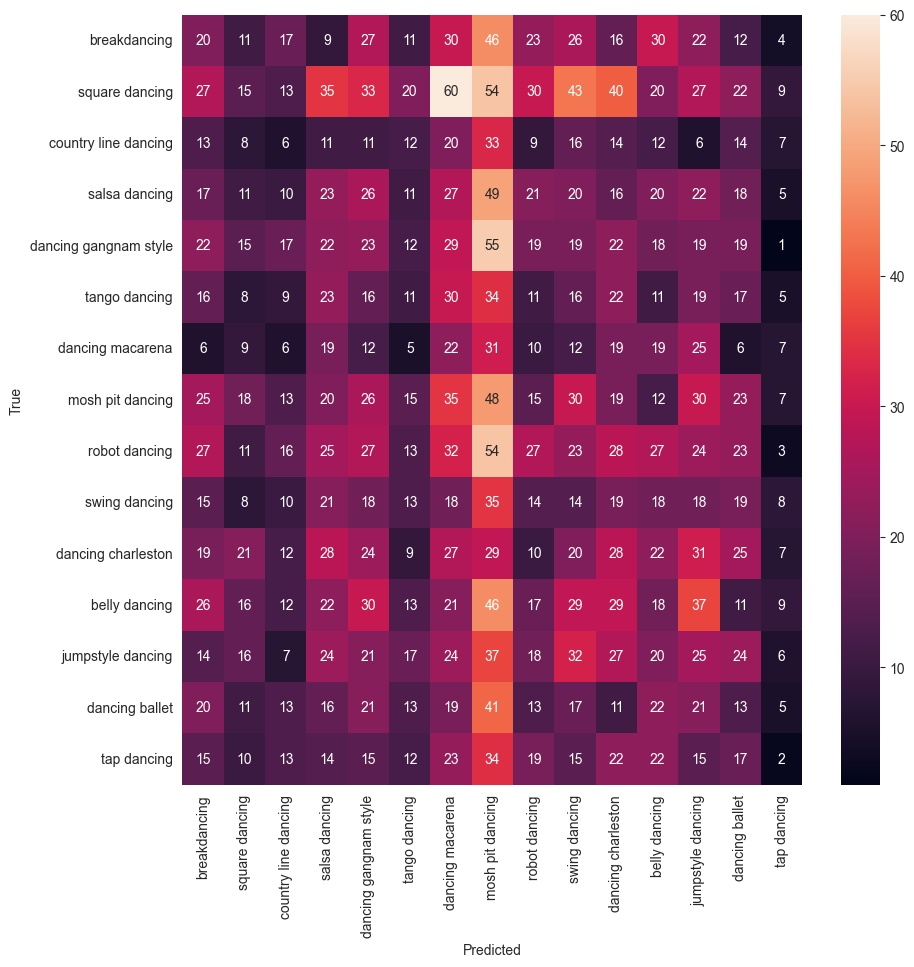

In [28]:
# make error matrix plot
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(10, 10))

sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Validation using voting

In [29]:
from collections import Counter

val_targets = []
val_preds = []

for i, batch in enumerate(val_dataloader):
    val_input, val_labels = batch
    # val_input = torch.swapaxes(val_input, 1, -2)

    grouped_inputs, grouped_labels = batch
    for j, video in enumerate(grouped_inputs):
        with torch.no_grad():
            frames_output = model(video.to(device))

        votes = torch.argmax(frames_output, dim=1)
        votes = votes.cpu().numpy()
        pred, num_most_common = Counter(votes).most_common(1)[0]

        val_preds.append(pred)
        val_targets.append(grouped_labels[j][0].item())

print('F1:', f1_score(val_targets, val_preds, average='macro'))
print('Accuracy:', accuracy_score(val_targets, val_preds))

F1: 0.06462987574041425
Accuracy: 0.06884057971014493


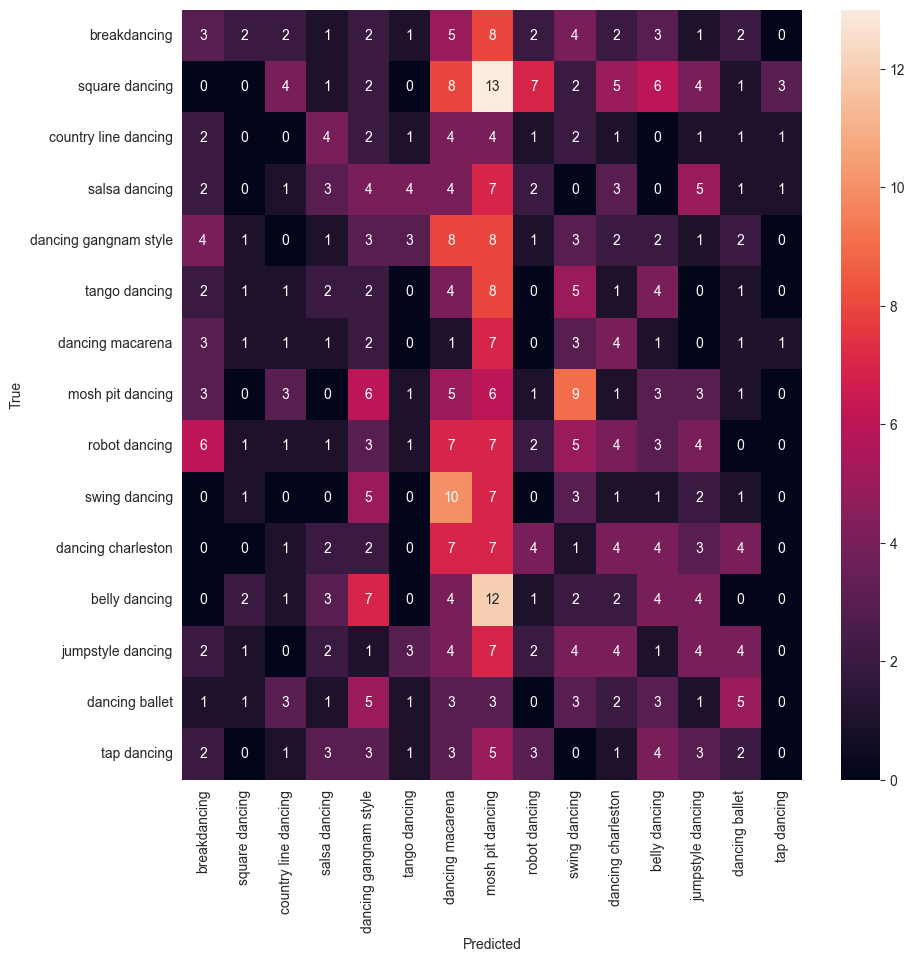

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(10, 10))

sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Validation using voting (before argmax)

In [31]:
val_targets = []
val_preds = []

for i, batch in enumerate(val_dataloader):
    val_input, val_labels = batch
    # val_input = torch.swapaxes(val_input, 1, -2)

    grouped_inputs, grouped_labels = batch
    for j, video in enumerate(grouped_inputs):
        with torch.no_grad():
            frames_output = model(video.to(device))

        votes = F.softmax(frames_output, dim=1)
        votes = votes.cpu().numpy()
        votes = np.mean(votes, axis=0)

        pred = np.argmax(votes)


        val_preds.append(pred)
        val_targets.append(grouped_labels[j][0].item())


print('F1:', f1_score(val_targets, val_preds, average='macro'))
print('Accuracy:', accuracy_score(val_targets, val_preds))

F1: 0.022412721647196654
Accuracy: 0.07246376811594203


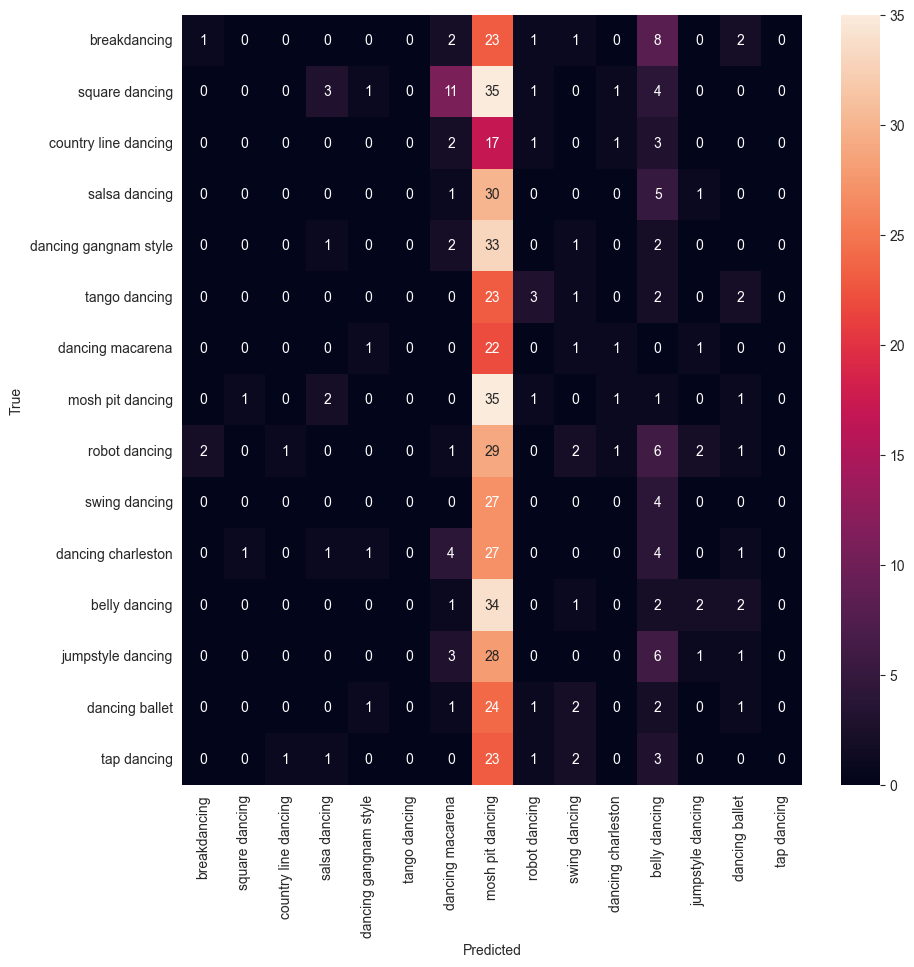

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(10, 10))

sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [33]:
X_train['label'].value_counts()

label
square dancing           131
mosh pit dancing         122
belly dancing            122
tango dancing            121
dancing gangnam style    116
jumpstyle dancing        115
tap dancing              110
dancing macarena         108
dancing charleston       107
salsa dancing            104
breakdancing             102
robot dancing            102
dancing ballet           102
swing dancing            101
country line dancing      93
Name: count, dtype: int64

In [34]:
X_val['label'].value_counts()


label
square dancing           56
robot dancing            45
belly dancing            42
mosh pit dancing         42
jumpstyle dancing        39
dancing gangnam style    39
dancing charleston       39
breakdancing             38
salsa dancing            37
dancing ballet           32
tango dancing            31
tap dancing              31
swing dancing            31
dancing macarena         26
country line dancing     24
Name: count, dtype: int64